# Lab-8 Template

Change title and notebook name to reflect your work.

Answer questions in the designated cells

Resources: 
- https://github.com/slundberg/shap
- H2O Explainability best practices: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb


## Preparation

Use dataset provided in the eLearning

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 

#Install shap package as needed:
#!pip uninstall numpy
#!pip uninstall numba
#!pip install shap==0.40.0

import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

try:
    h2o.cluster().shutdown()
except:
    pass 

In [3]:
#Limit to 3 threads and 8GB memory - modify as needed
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 23 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,3 months and 30 days !!!
H2O_cluster_name:,H2O_from_python_srbuj_iqgvba
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.833 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


### Load data

In [4]:
train = h2o.import_file('SBA_loans_train(3).csv')
test = h2o.import_file('SBA_loans_test(3).csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
train.head(5)

City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2,2,1,0,1,N,N,25000,0,25000,21250,1
SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2,0,0,0,0,N,N,52000,0,52000,46800,1
BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1,0,0,1,1,0,Y,150000,0,150000,127500,0
AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1,0,20,10625,2,Y,N,186959,0,100000,50000,1
HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1,0,0,1,1,0,Y,50000,0,50000,40000,0


In [6]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (337186, 20)
Test shape: (112396, 20)


# Prepare Dataset

Prepare dataframe by encoding some columns as categorical.

In [7]:
# Choose which columns to encode
cat_columns = ["City","State","Bank","BankState", "UrbanRural", "FranchiseCode",
               "NewExist", "RevLineCr","LowDoc", "Zip"]
response = "Defaulted"

train[cat_columns+[response]] = train[cat_columns+[response]].asfactor()

In [8]:
predictors = train.col_names[1:20]

In [9]:

response = "Defaulted"

## Question 1

Train H2O `H2OGradientBoostingEstimator` with parameters:
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='AUCPR',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

In [10]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [11]:
gbm_model = H2OGradientBoostingEstimator(nfolds = 5,
                                         ntrees = 500, 
                                         seed = 1234, 
                                         stopping_rounds = 5,
                                         stopping_metric = 'AUCPR',
                                         keep_cross_validation_predictions = False)

In [12]:
gbm_model.train(x = predictors,
               y = response,
               training_frame = train)

# retrieve the model performance
perf = gbm_model.model_performance(test)
perf

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.04214078503586889
RMSE: 0.20528220827891758
LogLoss: 0.14823083070423232
Mean Per-Class Error: 0.09837381565535763
AUC: 0.9746246046643332
AUCPR: 0.901364329604254
Gini: 0.9492492093286664

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4321338802598797: 


,,0,1,Error,Rate
0,0,89795.0,2894.0,0.0312,(2894.0/92689.0)
1,1,3262.0,16445.0,0.1655,(3262.0/19707.0)
2,Total,93057.0,19339.0,0.0548,(6156.0/112396.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.432134,0.842340,190.0
1,max f2,0.186417,0.872944,269.0
2,max f0point5,0.662457,0.864098,129.0
3,max accuracy,0.467514,0.945576,181.0
4,max precision,0.976426,0.979645,9.0
5,max recall,0.001733,1.000000,398.0
6,max specificity,0.995753,0.999978,0.0
7,max absolute_mcc,0.442509,0.809316,187.0
8,max min_per_class_accuracy,0.192246,0.922537,267.0
9,max mean_per_class_accuracy,0.186417,0.922829,269.0



Gains/Lift Table: Avg response rate: 17.53 %, avg score: 17.72 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010000,0.978697,5.576500,5.576500,0.977758,0.984800,0.977758,0.984800,0.055767,0.055767,457.650018,457.650018,0.055497
1,2,0.020001,0.970208,5.525759,5.551129,0.968861,0.974290,0.973310,0.979545,0.055260,0.111027,452.575859,455.112938,0.110379
2,3,0.030001,0.962123,5.454720,5.518993,0.956406,0.966094,0.967675,0.975061,0.054549,0.165576,445.472037,451.899305,0.164400
3,4,0.040001,0.953419,5.469943,5.506730,0.959075,0.957904,0.965525,0.970772,0.054701,0.220277,446.994285,450.673050,0.218605
4,5,0.050002,0.944327,5.414127,5.488210,0.949288,0.949013,0.962278,0.966420,0.054143,0.274420,441.412710,448.820982,0.272133
5,6,0.100004,0.860058,5.271036,5.379623,0.924199,0.909495,0.943238,0.937957,0.263561,0.537981,427.103584,437.962283,0.531098
6,7,0.150005,0.590488,4.511942,5.090396,0.791103,0.745703,0.892527,0.873873,0.225605,0.763587,351.194173,409.039579,0.744037
7,8,0.200007,0.276276,2.492427,4.440904,0.437011,0.419212,0.778648,0.760207,0.124626,0.888212,149.242665,344.090351,0.834527
8,9,0.300002,0.074014,0.812445,3.231489,0.142450,0.149517,0.566595,0.556656,0.081240,0.969452,-18.755494,223.148910,0.811785
9,10,0.400005,0.029673,0.174044,2.467111,0.030516,0.046495,0.432572,0.429113,0.017405,0.986857,-82.595636,146.711073,0.711625


## Question 2

Use model from Question 1 to answer Q#2.

- Calculate and display permutation feature importance for the model using **test** dataset
- What is most important feature?
- Can you tell how feature is impacting (direction) probability? 

In [13]:
permutation_varimp = gbm_model.permutation_importance(test, use_pandas=True)
permutation_varimp

,Relative Importance,Scaled Importance,Percentage
Variable,,,
Term,0.420463,1.000000,0.898078
BankState,0.015916,0.037853,0.033995
RevLineCr,0.005343,0.012706,0.011411
UrbanRural,0.004878,0.011601,0.010419
NAICS,0.004625,0.011000,0.009879
State,0.003740,0.008896,0.007989
FranchiseCode,0.003625,0.008621,0.007742
DisbursementGross,0.003421,0.008137,0.007308
Bank,0.002767,0.006582,0.005911


#### The most important feature is "Term" 

Predicting probabilities instead of class labels for a classification problem can provide additional uncertainty for the predictions.A feature may influence probability estimates without changing the predicted class label,scoring features according to their effect on probability estimates is more sensitive

## Question 3

Calculate and plot PDP plot for `"UrbanRural","SBA_Appv","DisbursementGross"]`

You might find using following parameters useful: `nbins=52,figsize=(10, 10)` 

What is your conclusion for each of the variables?

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model GBM_model_python_1650569059343_270 on column 'UrbanRural'.


,urbanrural,mean_response,stddev_response,std_error_mean_response
0,0,0.127608,0.238077,0.000410
1,1,0.183285,0.315648,0.000544
2,2,0.183900,0.313344,0.000540



PartialDependence: Partial Dependence Plot of model GBM_model_python_1650569059343_270 on column 'SBA_Appv'.


,sba_appv,mean_response,stddev_response,std_error_mean_response
0,1.000000e+02,0.160162,0.302783,0.000521
1,9.556863e+04,0.172133,0.308444,0.000531
2,1.910373e+05,0.181114,0.311051,0.000536
3,2.865059e+05,0.180460,0.307297,0.000529
4,3.819745e+05,0.180655,0.307032,0.000529
5,4.774431e+05,0.179545,0.305207,0.000526
6,5.729118e+05,0.179517,0.305171,0.000526
7,6.683804e+05,0.179517,0.305171,0.000526
8,7.638490e+05,0.177502,0.302848,0.000522
9,8.593176e+05,0.177059,0.301996,0.000520



See the whole table with table.as_data_frame()

PartialDependence: Partial Dependence Plot of model GBM_model_python_1650569059343_270 on column 'DisbursementGross'.


,disbursementgross,mean_response,stddev_response,std_error_mean_response
0,0.000000e+00,0.075121,0.174137,0.000300
1,2.156863e+05,0.184241,0.318431,0.000548
2,4.313725e+05,0.181866,0.316080,0.000544
3,6.470588e+05,0.181768,0.315868,0.000544
4,8.627451e+05,0.175562,0.308919,0.000532
5,1.078431e+06,0.164417,0.300981,0.000518
6,1.294118e+06,0.160709,0.296086,0.000510
7,1.509804e+06,0.160709,0.296086,0.000510
8,1.725490e+06,0.160709,0.296086,0.000510
9,1.941176e+06,0.155779,0.292008,0.000503



See the whole table with table.as_data_frame()


[, , ]

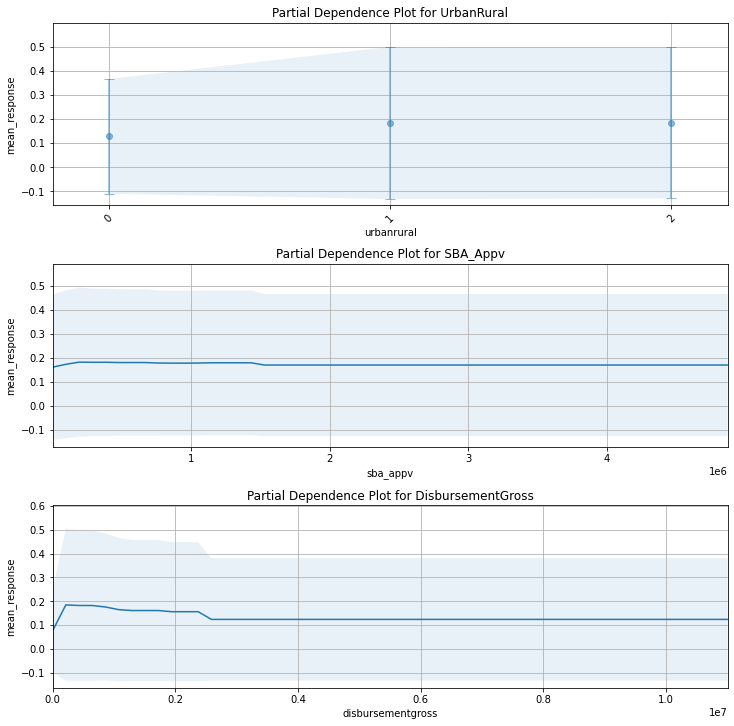

In [14]:
# build a 1-dimensional partial dependence plot:
gbm_model.partial_plot(data = train, cols = ["UrbanRural","SBA_Appv","DisbursementGross"],plot = True,nbins = 52,
                                  figsize=(10,10))



PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


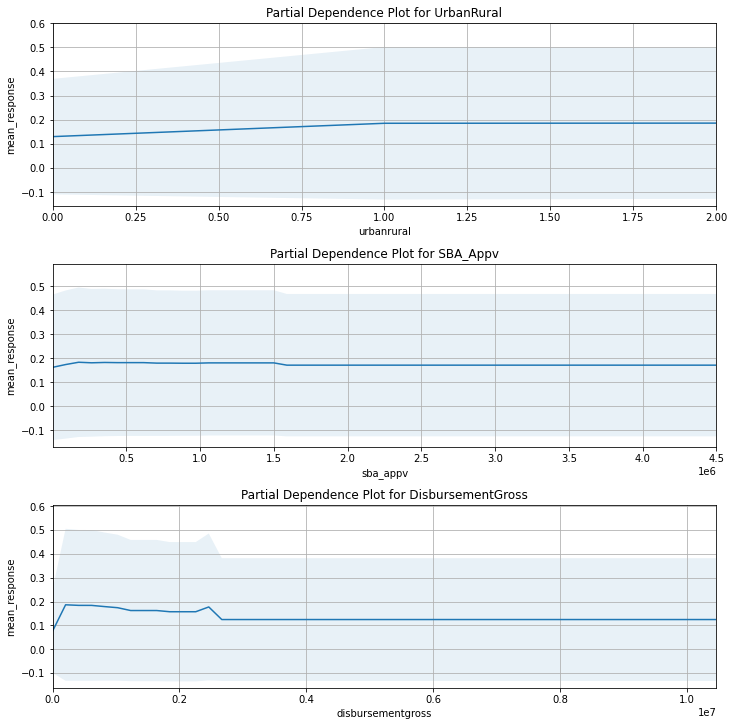

In [15]:
gbm_model.partial_plot(data = test, cols = ["UrbanRural","SBA_Appv","DisbursementGross"],plot = True,nbins = 52,
                                  figsize=(10,10))


The plots above show that when the response(Defaulted) is plotted against each of the features UrbanRural, SBA_Appv and Disbursement_Gross, we see that the features UrbanRural and SBA_Appv have greater influence on the outcome compared to the feature Disbursement_Gross.

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


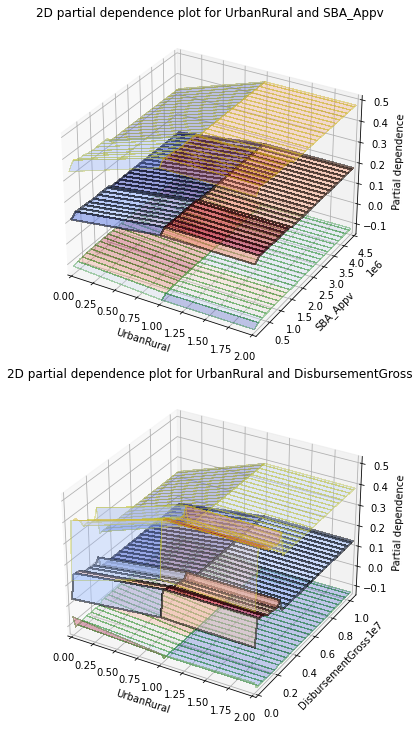

In [16]:
pdp2dOn = gbm_model.partial_plot(data = test,
                                  plot = True,
                                  nbins = 52,
                                  figsize=(10,10),
                                  col_pairs_2dpdp = [['UrbanRural','SBA_Appv'],['UrbanRural', 'DisbursementGross']])

## Question 4

Calculate and display summary plot of Shapley values. Use `test` dataset to calculate Shapley values.

- What is the most important feature based on Shapley values? 
- Why "Zip" feature is not rated at the top when many of the obesrvations have significant high/low Shapley values? 

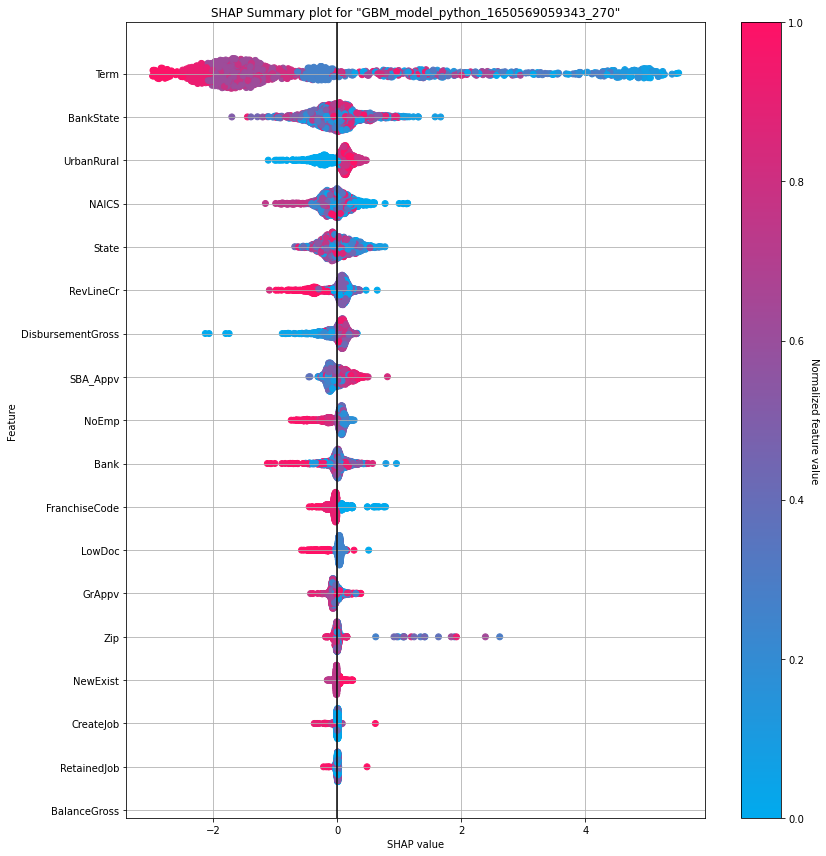

In [24]:
shap_plot = gbm_model.shap_summary_plot(test)

The most important feature based on shapley values is Term.

Given the current set of feature values, the contribution of a feature value(Zip) to the difference between the actual prediction and the mean prediction is the estimated Shapley value.The Shapley value returns a simple value per feature, but no prediction model. It cannot be used to make statements about changes in prediction for changes in the input. 

In [17]:
# Predict the contributions using the GBM model and test data.
contributions = gbm_model.predict_contributions(test)
contributions

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,BiasTerm
0.210775,0.00615937,-0.276814,-0.23625,0.359485,-1.38244,0.0682866,0.043598,0.00336983,0.0089834,-0.179151,-0.122143,0.0965091,-0.435809,-0.0996627,0,-0.0601864,-0.19502,-3.1657
0.191703,-0.00667864,-0.059687,0.0486499,0.427943,-1.07893,0.0276468,-0.0112681,0.00219108,0.00472392,-0.153984,-0.171612,0.0524339,0.118914,-0.0503333,0,-0.0623874,-0.191326,-3.1657
0.384349,0.00604951,-0.00229963,-0.209094,0.276809,-2.30311,-0.229021,-0.0211394,-0.0672723,0.0090718,-0.13324,-0.122314,0.0416119,0.0549528,0.0640956,0,-0.0495999,0.175063,-3.1657
-0.243963,0.0010555,0.0111867,-0.0999053,-0.108507,-1.61364,-0.163269,-0.0165566,-0.00483292,0.0173961,-0.0297028,0.0956965,-0.380328,0.0270149,-0.114126,0,-0.0211119,-0.106657,-3.1657
-0.0584533,0.00401867,0.0465011,-0.00629843,-0.258734,-1.64054,0.0483503,0.0299919,0.00997502,0.00868818,-0.0496814,0.0901723,0.143456,0.0378627,0.0740505,0,-0.0690866,-0.156955,-3.1657
0.140875,-0.00490655,0.0435088,0.00194029,0.260063,-0.774784,0.0880393,-0.0111868,0.0164296,0.00865445,-0.14111,-0.113503,0.0342117,0.0835209,0.0871442,0,-0.0211105,0.182387,-3.1657
-0.136842,-0.00152225,0.23074,0.371621,-0.15963,3.99911,0.0917416,-0.00356185,0.00706669,0.0113747,0.0763098,0.365511,0.0661362,0.0691398,0.0716464,0,-0.0339585,-0.128714,-3.1657
-0.00198816,0.0154082,-0.00765356,-0.169545,0.0435404,-1.57122,0.0315213,-0.00765853,0.0413662,0.00871591,-0.039292,0.0400083,-0.519209,0.0366612,0.0132531,0,-0.0609337,-0.171556,-3.1657
0.131698,-0.0259719,0.0279728,-0.125231,-0.00931836,1.02929,0.10596,-0.0105016,0.0136877,-0.00499349,-0.0250419,0.376345,0.0907083,0.0437967,0.119662,0,0.0326247,0.173098,-3.1657
-0.165487,-0.000171563,-0.395647,-0.536316,0.331594,-0.890835,-0.392978,-0.0450662,0.000946954,0.00697722,-0.129037,-0.122636,0.154158,0.0821235,0.115032,0,-0.0459271,0.108247,-3.1657


In [18]:
# Load JS visualization code
shap.initjs()

In [19]:
# Convert the H2OFrame to use with SHAP's visualization functions
contributions_matrix = contributions.as_data_frame().to_numpy()

In [20]:
# Calculate SHAP values for all features
shap_values = contributions_matrix[:,0:4]
shap_values

array([[ 2.10775390e-01,  6.15937309e-03, -2.76814222e-01,
        -2.36250207e-01],
       [ 1.91702962e-01, -6.67864084e-03, -5.96869960e-02,
         4.86498550e-02],
       [ 3.84348541e-01,  6.04950869e-03, -2.29962915e-03,
        -2.09094375e-01],
       ...,
       [ 2.32823327e-01,  1.89845978e-05,  1.54047742e-01,
         1.00594115e+00],
       [ 2.30879769e-01, -4.03545890e-03,  4.94312420e-02,
         1.64733186e-01],
       [-1.05140321e-01, -7.98471738e-03,  7.57927448e-03,
        -2.37279445e-01]])

In [21]:
# Expected values is the last returned column
expected_value = contributions_matrix[:,4].min()

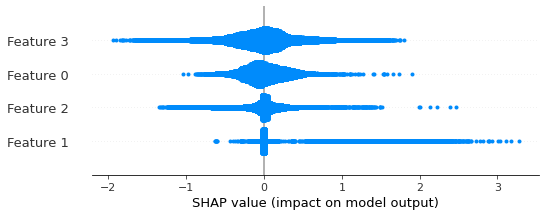

In [22]:
# Summarize the effects of all the features
shap.summary_plot(shap_values)

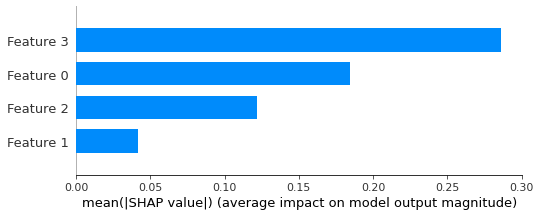

In [23]:
# View the same summary as a bar chart
shap.summary_plot(shap_values,plot_type="bar")

## Question 5

Plot individual Shapley values plots for records 0,1 and 4 in test dataset, for the total of 3 plots.
Explain each plot in terms of what are most influential  features and how they impact model prediction.

In [26]:
contributions_matrix_1 = contributions.as_data_frame()
# Calculate individual SHAP values for records 0,1 and 4
shap_values_1 = contributions_matrix_1.iloc[[0],:]
print(shap_values_1)
shap_values_2 = contributions_matrix_1.iloc[[1],:]
print(shap_values_2)
shap_values_3 = contributions_matrix_1.iloc[[4],:]
print(shap_values_3)


      State       Zip      Bank  BankState     NAICS      Term     NoEmp  \
0  0.210775  0.006159 -0.276814   -0.23625  0.359485 -1.382439  0.068287   

   NewExist  CreateJob  RetainedJob  FranchiseCode  UrbanRural  RevLineCr  \
0  0.043598    0.00337     0.008983      -0.179151   -0.122143   0.096509   

     LowDoc  DisbursementGross  BalanceGross    GrAppv  SBA_Appv  BiasTerm  
0 -0.435809          -0.099663             0 -0.060186  -0.19502 -3.165703  
      State       Zip      Bank  BankState     NAICS      Term     NoEmp  \
1  0.191703 -0.006679 -0.059687    0.04865  0.427943 -1.078932  0.027647   

   NewExist  CreateJob  RetainedJob  FranchiseCode  UrbanRural  RevLineCr  \
1 -0.011268   0.002191     0.004724      -0.153984   -0.171612   0.052434   

     LowDoc  DisbursementGross  BalanceGross    GrAppv  SBA_Appv  BiasTerm  
1  0.118914          -0.050333             0 -0.062387 -0.191326 -3.165703  
      State       Zip      Bank  BankState     NAICS      Term    NoEmp  \
4

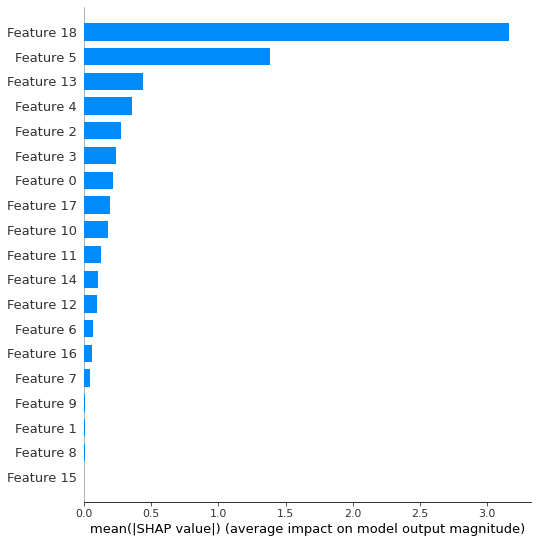

In [27]:
shap.summary_plot(shap_values_1,plot_type="bar")

The most influential features for record 0 are Feature 18(SBA_Appv), Feature 5(NAICS), Feature 13(RevLineCr)

The interpretation of the Shapley value for feature 18  is: The value of the 18-th feature contributed  
ϕ to the prediction of this particular instance compared to the average prediction for the dataset.

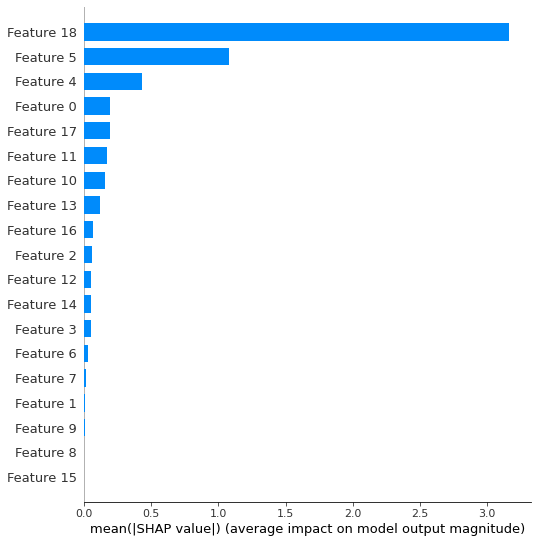

In [29]:
shap.summary_plot(shap_values_2,plot_type="bar")

The most influential features for record 1 are Feature 18(SBA_Appv), Feature 5(NAICS), Feature 4(BankState)

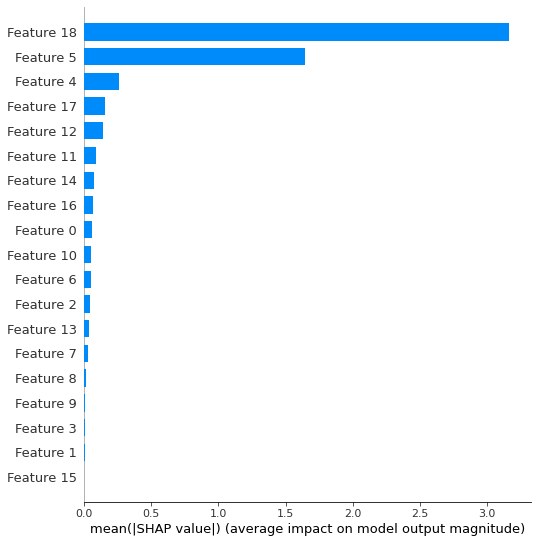

In [30]:
shap.summary_plot(shap_values_3,plot_type="bar")

The most influential features for record 4 are Feature 18(SBA_Appv), Feature 5(NAICS), Feature 4(BankState)

## Question 6 - optional (no points)

Train decision tree surrogate model with 4 levels and plot the result.